### 11.1 下载数据 并装入Dataframe

In [1]:
import urllib.request
import os
import tarfile
import xlrd
import pandas as pd

In [2]:
url = "http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls"
filepath = "C:/Users/Administrator/Desktop/data/titanic3.xls"
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print('downloaded',result)

In [3]:
all_df = pd.read_excel('C:/Users/Administrator/Desktop/data/titanic3.xls')

In [4]:
all_df[:2]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


### 11.2 数据预处理

In [5]:
cols = ['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']

In [6]:
all_df = all_df[cols]

In [7]:
all_df[:2]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S


In [8]:
#名字在预测阶段会用    所以在训练阶段先舍去
#年龄null   fare null将其填成平均值
#性别分为  female = 0  male = 1
#embarked使用One-Hot Encoding进行转换

In [9]:
df = all_df.drop(['name'],axis=1)

In [10]:
all_df.isnull().sum()

survived      0
name          0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [11]:
age_mean = df['age'].mean()

df['age'] = df['age'].fillna(age_mean)

fare_mean = df['fare'].mean()

df['fare'] = df['fare'].fillna(fare_mean)

df['sex'] = df['sex'].map({'female':0,'male':1}).astype(int)

x_OneHot_df = pd.get_dummies(data= df,columns=['embarked'])

In [12]:
x_OneHot_df[:2]

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.0000,0,0,211.3375,0,0,1
1,1,1,1,0.9167,1,2,151.5500,0,0,1


In [13]:
#将DataFrame转换为Array

In [14]:
ndarry = x_OneHot_df.values

In [15]:
ndarry.shape

(1309, 10)

In [16]:
ndarry[:2]

array([[  1.    ,   1.    ,   0.    ,  29.    ,   0.    ,   0.    ,
        211.3375,   0.    ,   0.    ,   1.    ],
       [  1.    ,   1.    ,   1.    ,   0.9167,   1.    ,   2.    ,
        151.55  ,   0.    ,   0.    ,   1.    ]])

In [17]:
Label = ndarry[:,0]

Feature = ndarry[:,1:]

In [18]:
Label[:2]

array([1., 1.])

In [19]:
Feature[:2]

array([[  1.    ,   0.    ,  29.    ,   0.    ,   0.    , 211.3375,
          0.    ,   0.    ,   1.    ],
       [  1.    ,   1.    ,   0.9167,   1.    ,   2.    , 151.55  ,
          0.    ,   0.    ,   1.    ]])

In [20]:
#将ndarray特征字段进行标准化

In [21]:
from sklearn import preprocessing

In [22]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))

In [23]:
scaledFeatures = minmax_scale.fit_transform(Feature)

In [24]:
scaledFeatures[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [25]:
import numpy

In [26]:
msk = numpy.random.rand(len(all_df)) < 0.8

In [27]:
train_df = all_df[msk]
test_df = all_df[~msk]

In [28]:
print('total:',len(all_df),'train:',len(train_df),'test:',len(test_df))

total: 1309 train: 1061 test: 248


In [29]:
def PreprocessData(raw_df):
    df = all_df.drop(['name'],axis=1)
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['sex'] = df['sex'].map({'female':0,'male':1}).astype(int)
    x_OneHot_df = pd.get_dummies(data= df,columns=['embarked'])
    
    ndarry = x_OneHot_df.values
    
    Label = ndarry[:,0]
    Feature = ndarry[:,1:]
    
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures = minmax_scale.fit_transform(Feature)
    
    return scaledFeatures,Label

In [30]:
train_Features,train_Label = PreprocessData(train_df)

In [31]:
test_Features,test_Label = PreprocessData(test_df)

In [32]:
train_Features[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [33]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

Using TensorFlow backend.


In [34]:
model = Sequential()

model.add(Dense(units=40,
               input_dim = 9,
               kernel_initializer='uniform',
               activation='relu'))

model.add(Dense(units=30,
               kernel_initializer='uniform',
               activation='relu'))

model.add(Dense(units=1,
               kernel_initializer='uniform',
               activation='sigmoid'))

In [35]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
train_history = model.fit(x=train_Features,y=train_Label,validation_split=0.1,epochs=30,batch_size=30,verbose=2)

Train on 1178 samples, validate on 131 samples
Epoch 1/30
 - 1s - loss: 0.6897 - acc: 0.5883 - val_loss: 0.6716 - val_acc: 0.7863
Epoch 2/30
 - 0s - loss: 0.6580 - acc: 0.6613 - val_loss: 0.5751 - val_acc: 0.8092
Epoch 3/30
 - 0s - loss: 0.5757 - acc: 0.7334 - val_loss: 0.4687 - val_acc: 0.8015
Epoch 4/30
 - 0s - loss: 0.5067 - acc: 0.7716 - val_loss: 0.4333 - val_acc: 0.8092
Epoch 5/30
 - 0s - loss: 0.4859 - acc: 0.7708 - val_loss: 0.4340 - val_acc: 0.8092
Epoch 6/30
 - 0s - loss: 0.4782 - acc: 0.7742 - val_loss: 0.4246 - val_acc: 0.8092
Epoch 7/30
 - 0s - loss: 0.4736 - acc: 0.7767 - val_loss: 0.4218 - val_acc: 0.8321
Epoch 8/30
 - 0s - loss: 0.4688 - acc: 0.7852 - val_loss: 0.4233 - val_acc: 0.8092
Epoch 9/30
 - 0s - loss: 0.4669 - acc: 0.7852 - val_loss: 0.4218 - val_acc: 0.8244
Epoch 10/30
 - 0s - loss: 0.4649 - acc: 0.7920 - val_loss: 0.4159 - val_acc: 0.8473
Epoch 11/30
 - 0s - loss: 0.4618 - acc: 0.7946 - val_loss: 0.4180 - val_acc: 0.8244
Epoch 12/30
 - 0s - loss: 0.4619 - acc

In [36]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

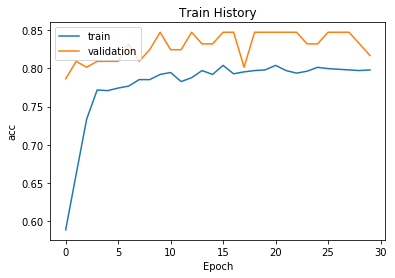

In [37]:
show_train_history(train_history,'acc','val_acc')

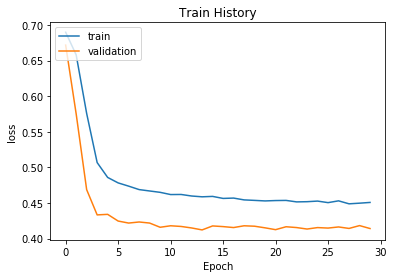

In [38]:
show_train_history(train_history,'loss','val_loss')

In [39]:
scores = model.evaluate(test_Features,test_Label)
print()
print('loss=',scores[0])
print('accuracy=',scores[1])

1309/1309 [==============================] - 0s 38us/step

loss= 0.4438657154556082
accuracy= 0.8036669214050491


### 12.5 加入《泰坦呢克号》电影中Jack与Rose的数据

In [40]:
Jack = pd.Series([0,'Jack',3,'male',23,1,0,5.0000,'S'])
Rose = pd.Series([1,'Rose',1,'female',20,1,0,100.0000,'S'])

In [41]:
JR_df = pd.DataFrame([list(Jack),list(Rose)],columns = ['survived','name','pclass','sex','age','sibsp','parch','fare','embarked'])

In [42]:
all_df = pd.concat([all_df,JR_df])

In [43]:
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


In [44]:
all_Features,Lable = PreprocessData(all_df)

In [45]:
all_probability = model.predict(all_Features)

In [46]:
all_probability[:10]

array([[0.97629845],
       [0.46977964],
       [0.9728845 ],
       [0.29177096],
       [0.968796  ],
       [0.2292522 ],
       [0.92531693],
       [0.2569107 ],
       [0.9248897 ],
       [0.24589437]], dtype=float32)

In [47]:
#将数据与预测生还率整合

In [48]:
pd = all_df
pd.insert(len(all_df.columns),'probability',all_probability)

In [49]:
pd[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.127422
1,1,Rose,1,female,20.0,1,0,100.0,S,0.971623


### 12.7 找出泰坦尼克号背后的感人故事

In [50]:
pd[(pd["survived"]==0)&(pd['probability']>0.9)]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.972884
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.968796
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.982026
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.978343
286,0,"Straus, Mrs. Isidor (Rosalie Ida Blun)",1,female,63.0,1,0,221.7792,S,0.935205
